In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
#Importing data
df = pd.read_csv('Train.csv')
#Printing head
df.head()


,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


### As seen from the print statements above, we are given 2 years of data(2012-2014) at hourly level with the number of commuters travelling and we need to estimate the number of commuters for future.


* Subsetting the dataset from (August 2012 – Dec 2013)
* Creating train and test file for modeling. The first 14 months (August 2012 – October 2013) are used as training data and next 2 months (Nov 2013 – Dec 2013) as testing data.
* Aggregating the dataset at daily basis

In [2]:
#Subsetting the dataset
#Index 11856 marks the end of year 2013
df = pd.read_csv('Train.csv', nrows = 11856)

#Creating train and test set 
#Index 10392 marks the end of October 2013 
train=df[0:10392] 
test=df[10392:]

#Aggregating the dataset at daily level
df.Timestamp = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M') 
df.index = df.Timestamp 
df = df.resample('D').mean()
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
train = train.resample('D').mean() 
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 
test = test.resample('D').mean()

/home/linu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # This is added back by InteractiveShellApp.init_path()
/home/linu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/home/linu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


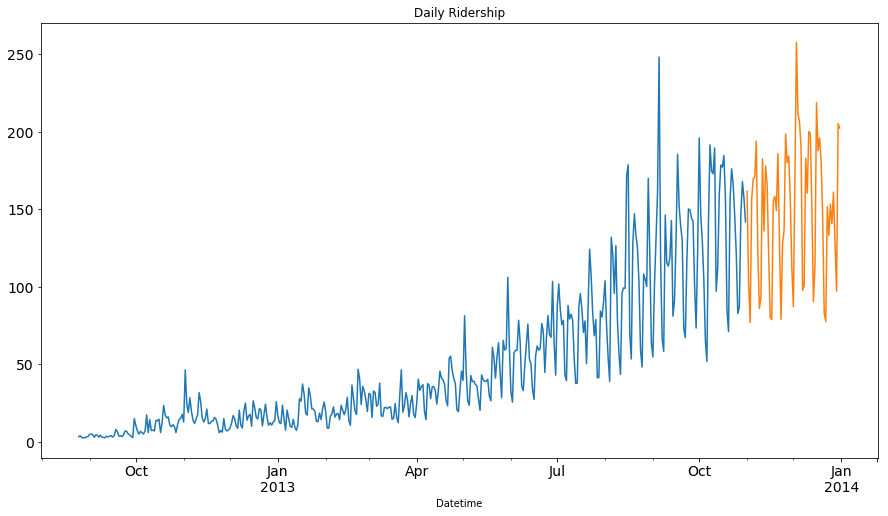

In [3]:
#Plotting data
train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
test.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()

# Method 1: Start with a Naive Approach

### Such forecasting technique which assumes that the next expected point is equal to the last observed point is called Naive Method.

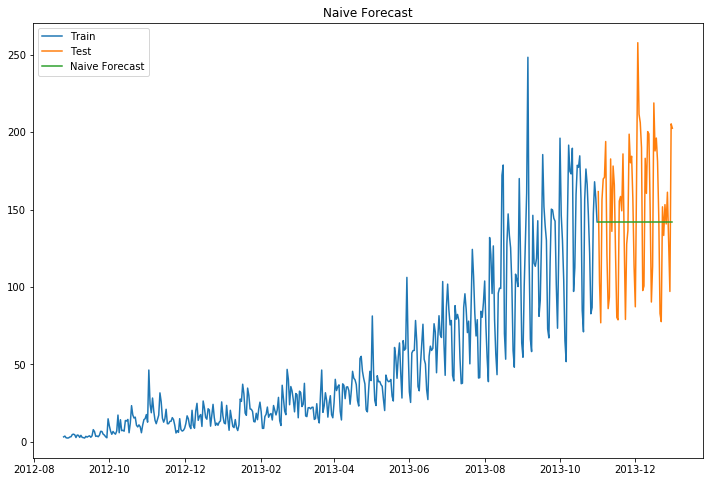

In [4]:
dd= np.asarray(train.Count)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

## We will now calculate RMSE to check to accuracy of our model on test data set.

In [5]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.Count, y_hat.naive))
print(rms)

43.91640614391676


#### We can infer from the RMSE value and the graph above, that Naive method isn’t suited for datasets with high variability. It is best suited for stable datasets. We can still improve our score by adopting different techniques. Now we will look at another technique and try to improve our score.

# Method 2: – Simple Average